---
title: "Speeding up Inference with TensorRT"
author: "chris"
date: 2024-05-27
draft: false
---

follow up post to pytorch quantization ... can we make it faster with GPU and TensorRT

In [1]:
# random colab error: "A UTF-8 locale is required. Got ANSI_X3.4-1968"
# https://github.com/googlecolab/colabtools/issues/3409

import locale
locale.getpreferredencoding = lambda: "UTF-8"

get FasterRCNN as before with a resnet101 backbone...

In [3]:
%%capture

import torch
from torchvision.models.resnet import ResNet, Bottleneck, ResNet101_Weights
from torchvision.models._utils import IntermediateLayerGetter
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torchvision.models.detection.faster_rcnn import FasterRCNN


def resnet_101():
    resnet = ResNet(block=Bottleneck, layers=[3, 4, 23, 3])
    resnet.load_state_dict(ResNet101_Weights.DEFAULT.get_state_dict(progress=True))
    return resnet


resnet = resnet_101()

# same as before, get intermediate layers and their output dimensions
returned_layers = [1, 2, 3, 4]
return_layers = {f"layer{k}": str(v) for v, k in enumerate(returned_layers)}
in_channels_list = []
for k1, m1 in resnet.named_children():
    if 'layer' in k1:
        in_channels_list.append((m1[-1].bn3.num_features))

rcnn = FasterRCNN(
    BackboneWithFPN(
        backbone=resnet,
        return_layers=return_layers,
        in_channels_list=in_channels_list,
        out_channels=256,
        extra_blocks=None,
        norm_layer=None,
        ),
    num_classes=2
)

rcnn.eval()

time the RCNN on both CPU and GPU.  I don't recall what the specs were the last time I used colab to profile the inference time so I'll document that here as well.  I'm using a T4 GPU and the following CPU

In [4]:
# !cat /proc/cpuinfo  | grep 'name' | uniq
!lscpu | grep 'name'

Model name:                           Intel(R) Xeon(R) CPU @ 2.20GHz


In [5]:
!nvidia-smi -L

GPU 0: NVIDIA L4 (UUID: GPU-393b8fe1-1ca8-7aaf-94b9-04eef8e2fda5)


In [109]:
# random image
image = torch.rand(3, 200, 200)
# put on CPU
rcnn.to(torch.device('cpu'))
image_cpu = image.to(torch.device('cpu'))

with torch.no_grad():
    cpu_time = %timeit -o rcnn([image_cpu])

1.47 s ± 137 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [110]:
from copy import deepcopy

# on GPU
rcnn_gpu = deepcopy(rcnn).to(torch.device('cuda'))
# rcnn.to(torch.device('cuda'))
image_gpu = image.to(torch.device('cuda'))

with torch.no_grad():
    gpu_time = %timeit -o rcnn_gpu([image_gpu])

37.9 ms ± 235 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


we can also test with half precision...

In [111]:
rcnn_gpu_half = rcnn_gpu.half().to(torch.device('cuda'))
input_half = image_gpu.half()

with torch.no_grad():
    gpu_half_time = %timeit -o rcnn_gpu_half([input_half])

29.1 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


also re-clock the quantized model using FX Graph Mode since it's performance is also CPU specific

In [11]:
%%capture
from torch.ao.quantization import quantize_fx
from torch.ao.quantization.qconfig_mapping import get_default_qconfig_mapping


quant_rcnn = deepcopy(rcnn)

qconfig_mapping = get_default_qconfig_mapping("fbgemm")  # "qnnpack"
# assume calibrated already
quant_rcnn.eval()
quant_rcnn.to(torch.device('cpu'))
# prepare and quantize
example_input = torch.randn(1, 3, 200, 200)
quant_rcnn.backbone = quantize_fx.prepare_fx(quant_rcnn.backbone, qconfig_mapping, example_input)
quant_rcnn.backbone = quantize_fx.convert_fx(quant_rcnn.backbone)

script_module = torch.jit.script(quant_rcnn)
script_module.save("./quant_rcnn.pt")
quant_rcnn_jit = torch.jit.load("./quant_rcnn.pt", map_location=torch.device('cpu'))

In [112]:
import warnings

# warmup
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for _ in range(3):
        __ = quant_rcnn_jit([image_cpu])

with torch.no_grad():
    quant_time = %timeit -o quant_rcnn_jit([image_cpu])

652 ms ± 81 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Below I convert the float model to onnx.  I went through onnx because that used to be the preferred way of converting to TensorRT.  However, the onnx conversion didn't play well with the `trtexec` command line utility for TensorRT regardless of the torch to onnx exporter used.  Below the [old torch script onnx converter](https://pytorch.org/docs/stable/onnx_torchscript.html) is used but the [newer 'dynamo' converter](https://pytorch.org/docs/stable/onnx_dynamo.html) also had issues.  Thankfully PyTorch has a very easy TensorRT API now, but I keep the ONNX model and evaluate it to see if a simple conversion offers any benefits.

In [14]:
%%capture

!pip install onnx
!pip install onnxruntime

In [8]:
import onnx

torch.onnx.export(
    deepcopy(rcnn),
    # onnx wants a tuple of 2 or bombs:  https://github.com/zhiqwang/yolort/issues/485
    ([torch.randn(3, 200, 200)], ),
    "rcnn.onnx",
    # do_constant_folding=True,
    opset_version = 11,
    verbose=False
    )
# make sure the onnx proto is valid
rcnn_onnx = onnx.load("rcnn.onnx")
onnx.checker.check_model(rcnn_onnx)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4009: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  (torch.floor((input.size(i + 2).float() * torch.tensor(scale_factors[i], dtype=torch.float32)).float()))
/usr/local/lib/python3.10/dist-packages/torchvision/ops/boxes.py:166: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes_x = torch.min(boxes_x, torch.tensor(width, dtype=boxes.dtype, device=boxes.device))
/usr/local/lib/python3.10/dist-packages/torchvision/ops/boxes.py:168: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bo

run inference on onnx model, make sure outputs are as expected, then clock-it...

In [20]:
import onnxruntime
import numpy as np

ort_session = onnxruntime.InferenceSession("rcnn.onnx", providers=["CPUExecutionProvider"])
# good to make sure inputs are as expected: '[i.name for i in ort_session.get_inputs()]'

# onnx wants numpy tensor not torch tensor
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# get a prediction.  onnx doesn't need a list input like torch model does
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(image)}
ort_outs = ort_session.run(None, ort_inputs)

In [22]:
# onxx outputs are list of three arrays corresponding to 'boxes', 'labels', and 'scores'
print("onnx out shapes: ", [arr.shape for arr in ort_outs])
# quant model out is tuple of (losses, outputs)
torch_outs = __[1][0]
print("torch out shapes: ", [torch_outs[k].shape for k in torch_outs])

onnx out shapes:  [(100, 4), (100,), (100,)]
torch out shapes:  [torch.Size([100, 4]), torch.Size([100]), torch.Size([100])]


In [113]:
onnx_time = %timeit -o ort_session.run(None, ort_inputs)

# sess = onnxruntime.InferenceSession('rcnn.onnx', providers=['TensorrtExecutionProvider', 'CUDAExecutionProvider'])
# onnx_trt_time = %timeit -o sess.run(None, ort_inputs)

1.05 s ± 114 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [87]:
# more steps for using trtexec which has issues with rcnn input shape
# !sudo apt-get install tensorrt
# !pip install tensorrt
# !ls /usr/src/tensorrt/bin  # make sure trtexec is there
# !/usr/src/tensorrt/bin/trtexec --onnx=rcnn.onnx --saveEngine=rcnn_engine_pytorch.trt

use the handy `torch-tensorrt` package...

In [57]:
%%capture

!python -m pip install torch-tensorrt

In [58]:
%%capture

device = torch.device("cuda")
rcnn.to(device)

In [92]:
import torch_tensorrt

# need to wrap rcnn inputs in list
inputs = [[torch.randn(3, 200, 200).to("cuda")]]  # .half()]

trt_model = torch_tensorrt.compile(
    deepcopy(rcnn),
    ir="torch_compile",
    # frontend api below complains about input shape
    # backend="torch_tensorrt",
    inputs=inputs,
    enabled_precisions={torch.float32},  #  {torch.half}
    debug=True,
    workspace_size=20 << 30,
    min_block_size=7,
    torch_executed_ops={},
)

In [93]:
%%capture

# contrary to docs, first run actually compiles model
# https://pytorch.org/TensorRT/tutorials/_rendered_examples/dynamo/torch_compile_resnet_example.html#torch-compile-resnet
outputs = trt_model(*inputs)

Streaming output truncated to the last 5000 lines.
    %_tensor_constant140 : [num_users=1] = get_attr[target=_tensor_constant140]
    %_tensor_constant141 : [num_users=1] = get_attr[target=_tensor_constant141]
    %_native_batch_norm_legit_no_training_69 : [num_users=1] = call_function[target=torch.ops.aten._native_batch_norm_legit_no_training.default](args = (%convolution_69, %_param_constant208, %_param_constant209, %_tensor_constant140, %_tensor_constant141, 0.1, 1e-05), kwargs = {})
    %getitem_209 : [num_users=1] = call_function[target=operator.getitem](args = (%_native_batch_norm_legit_no_training_69, 0), kwargs = {})
    %add_28 : [num_users=1] = call_function[target=torch.ops.aten.add.Tensor](args = (%getitem_209, %relu_63), kwargs = {})
    %relu_66 : [num_users=2] = call_function[target=torch.ops.aten.relu.default](args = (%add_28,), kwargs = {})
    %_param_constant210 : [num_users=1] = get_attr[target=_param_constant210]
    %convolution_70 : [num_users=1] = call_function

In [115]:
trt_time = %timeit -o trt_model(*inputs)

26.1 ms ± 207 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


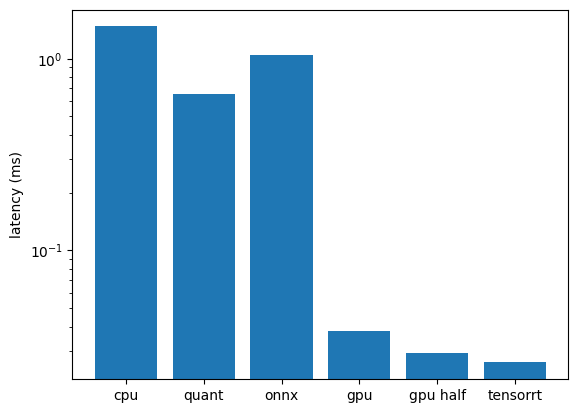

In [117]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

runtime = [
    'cpu',
    'quant',
    'onnx',
    'gpu',
    'gpu half',
    'tensorrt'
    ]
latency = [
    cpu_time.average,
    quant_time.average,
    onnx_time.average,
    gpu_time.average,
    gpu_half_time.average,
    trt_time.average
    ]
latency = [round(n, 3) for n in latency]

ax.bar(runtime, latency)

ax.set_ylabel('latency (ms)')
ax.set_yscale('log')

plt.show()

... half precision on the GPU is nearly as fast as TensorRT.. with TensorRT can also use half-precision to improve latency even more ...

In [ ]:
#| code-fold: true
# plot latency for all methods (bar chart)